In [1]:
#Store Item Demand Forecasting Challenge: Kaggle
#Predicting Item Demands
#Time Series Analysis by Sudesh Khillare

In [2]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,8
from datetime import datetime
import itertools
import matplotlib.dates as mdates

In [3]:
dataset=pd.read_csv('train.csv')
dataset.head()

,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10


1. Here can be two approaches, single model to predict the sales of all items, of individual models for individual items.
2. Here Considering sales prediction for only item 1 with item id=1

In [4]:
data=dataset[dataset.item==1]
print('Dimension of dataset are:' ,data.shape)
data.head()

Dimension of dataset are: (18260, 4)


,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10


In [5]:
#converting to datetime format
data['date']=pd.to_datetime(data['date'],infer_datetime_format=True)

D:\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
#As we are prediting over all sales, thus grouping by Date to find total sales across all the stores
data_grouped = data.groupby('date', as_index=False).sum()
data_grouped.head()

,date,store,item,sales
0,2013-01-01,55,10,133
1,2013-01-02,55,10,99
2,2013-01-03,55,10,127
3,2013-01-04,55,10,145
4,2013-01-05,55,10,149


In [7]:
#Now as all datapoints are with respect to same item, we can drop it, and we are predicting total sales of item on particular date, thus dropping the store column
data_grouped=data_grouped.drop(['store','item'],axis=1)
data_grouped.head()

,date,sales
0,2013-01-01,133
1,2013-01-02,99
2,2013-01-03,127
3,2013-01-04,145
4,2013-01-05,149


In [8]:
#Now resetting the index to date to boil down problem or univariate time series analysis
indexedDataset=data_grouped.set_index(['date'])
indexedDataset.head()

,sales
date,
2013-01-01,133
2013-01-02,99
2013-01-03,127
2013-01-04,145
2013-01-05,149


In [9]:
#Storing 1461 datapoints in Training Dataset and 365 datapoints i.e. one year in test dataset
train = indexedDataset.iloc[:-365, :]
test = indexedDataset.iloc[-365:, :]

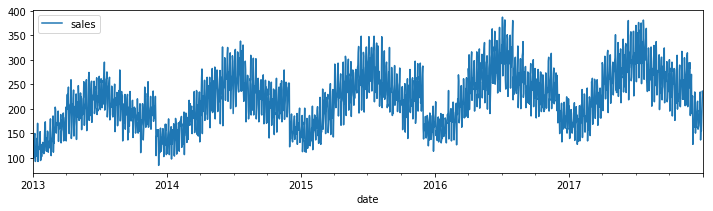

In [10]:
pred = test.copy()
#Plotting original data
indexedDataset.plot(figsize=(12,3));

In [11]:
Stat_Check=indexedDataset.copy()

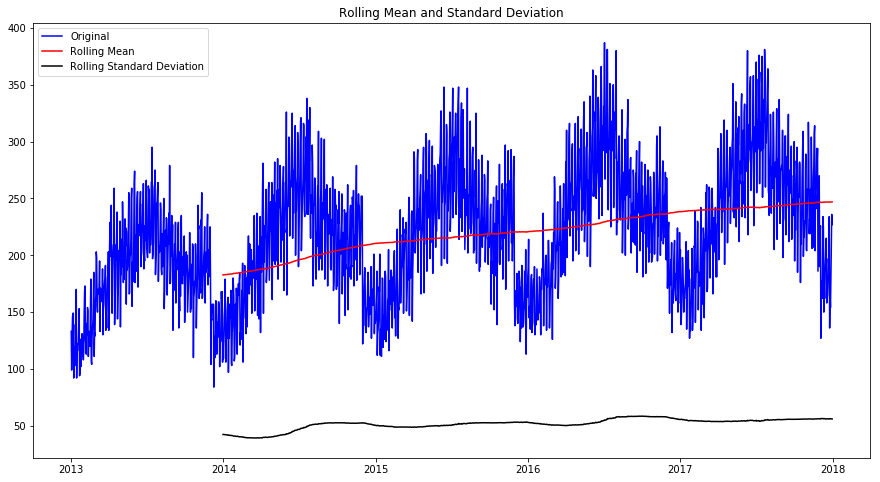

In [14]:
#Rolling Statistics over period of 365 days
RolMean=Stat_Check.rolling(window=365).mean()
RolStd=Stat_Check.rolling(window=365).std()
rcParams['figure.figsize']=15,8
#print(RolMean,RolStd)

#Plotting ROlling Statistics
Original=plt.plot(Stat_Check, color='blue', label='Original')
Mean=plt.plot(RolMean, color='red', label='Rolling Mean')
Std=plt.plot(RolStd, color='Black', label='Rolling Standard Deviation')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

In [15]:
#Dickey-Fuller Test: Fot Stationarity
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test')
dftest=adfuller(indexedDataset['sales'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test_Statistics', 'P_Value','#Lags_Used','No_Of_Observations_Used'])

for key,value in dftest[4].items():
    dfoutput['Critical_Value %s'%key]= value
print(dfoutput)

Results of Dickey-Fuller Test
Test_Statistics              -3.051073
P_Value                       0.030392
#Lags_Used                   24.000000
No_Of_Observations_Used    1801.000000
Critical_Value 1%            -3.433986
Critical_Value 5%            -2.863146
Critical_Value 10%           -2.567625
dtype: float64


1. Here Critial value with 5% almost same as Test_Statistics and P_Value is less than 0.05
2. From the data plot and Dicky Fuller test, we can confirm Moving Averages have very slight upward trend and standard deviation is almost constant but data have seasonality with period of 1 year.

# 1. Traditional Regression Approach

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     445.3
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           1.91e-86
Time:                        19:32:21   Log-Likelihood:                -7402.1
No. Observations:                1455   AIC:                         1.481e+04
Df Residuals:                    1453   BIC:                         1.482e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        175.7002      2.055     85.493      0.0

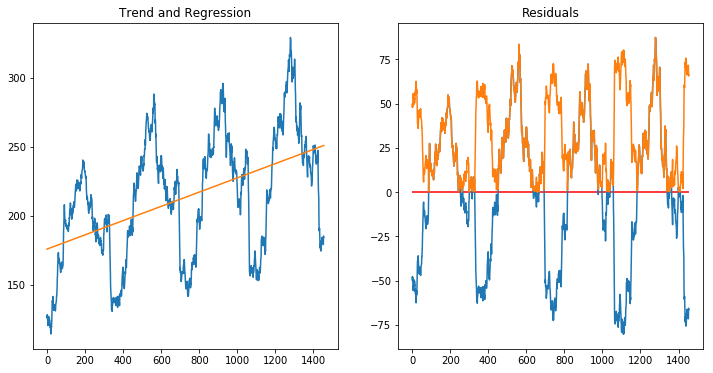

In [16]:
import statsmodels.api as sm
from statsmodels.api import OLS

#Using Decomposing approach
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train)

x, y = np.arange(len(decomposition.trend.dropna())), decomposition.trend.dropna()
x = sm.add_constant(x)
model = OLS(y, x)
res = model.fit()
print(res.summary())
fig, ax = plt.subplots(1, 2, figsize=(12,6));
ax[0].plot(decomposition.trend.dropna().values, label='trend')
ax[0].plot([res.params.x1*i + res.params.const for i in np.arange(len(decomposition.trend.dropna()))])
ax[1].plot(res.resid.values);
ax[1].plot(np.abs(res.resid.values));
ax[1].hlines(0, 0, len(res.resid), color='r');
ax[0].set_title("Trend and Regression");
ax[1].set_title("Residuals");

1. Here R Squared Value is very low i.e. less than 25% and from above regression line and residuals plot we can confirm this is not a good fit.
2. Thus moving to time series approach.

# 2. Holt-Winter's Seasonal Smoothing

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Model 1: Calculation of seasonality over year
#Additive Trend
model = ExponentialSmoothing(train, trend="mul", seasonal="add", seasonal_periods=365)
fit = model.fit()

#Predicting for next 1 year and matching that with our test set.
pred = fit.forecast(365)
#Model 1 RMSE
sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))


#Model 2: Calculation of seasonality over year by damping
#Multiplicative Trend and Season
#As there is very small linear increase in trend, using damping model to incorporate that trend.
model2 = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=365, damped=True)
fit2 = model2.fit()
#Predicting for next 1 year and matching that with our test set.
pred2 = fit2.forecast(365)
#Model 2 RMSE
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))



D:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Python\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
D:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Python\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [32]:
print('RMSE without damping is', sse1, 'and RMSE with damping is ', sse2)

RMSE without damping is 76.6268344589965 and RMSE with damping is  72.88410042429781


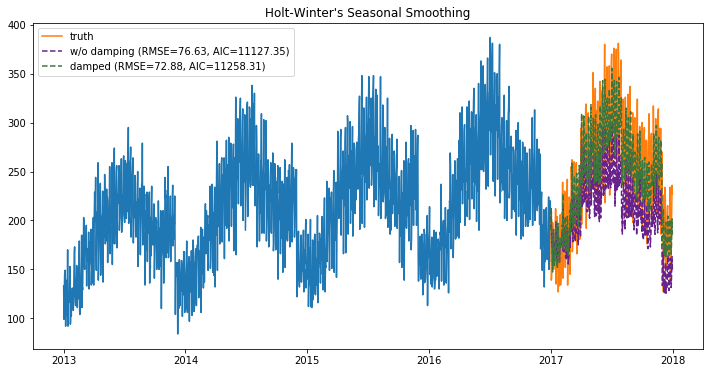

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
#Training Analysis
ax.plot(train.index, train.values);

#Test Data Analysis
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#68228B', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

1. RMSE for Damping model is less than other model.
2. From plot, Damping model is more close fit to original data
3. Thus in, Holts-Winter test, best model is Exponential Smoothing with Damping and Multiplicative seasonality and Trend

# 3. Seasonal ARIMA

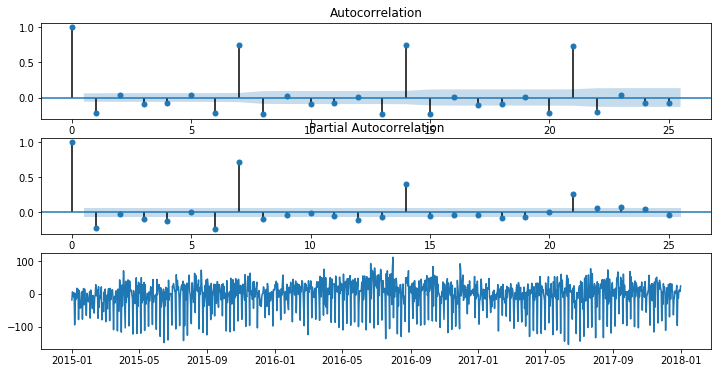

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Stationary data
indexedDataset['sales'] = indexedDataset.sales - indexedDataset.sales.rolling(365).mean()

fig, ax = plt.subplots(3, figsize=(12,6))
x = (indexedDataset.sales.dropna() - indexedDataset.sales.dropna().shift(365)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

In [44]:
train_st = indexedDataset.ix[:, "sales"]
train_st.tail()

D:\Python\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


date
2017-12-27   -92.747945
2017-12-28   -68.802740
2017-12-29   -39.860274
2017-12-30   -10.904110
2017-12-31   -19.994521
Name: sales, dtype: float64

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
train_st = indexedDataset.ix[:, "sales"]
sarima_model = SARIMAX(train_st, order=(0, 1, 2), seasonal_order=(0, 1, 2, 12), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

D:\Python\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
D:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [46]:
#Storing last 365 datapoints as test set
test_st = indexedDataset.ix[-365:, "sales"]
test_st.shape

D:\Python\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


(365,)

In [47]:
#sarima_pred = sarima_fit.get_prediction( dynamic=False)
sarima_pred = sarima_fit.get_prediction("2017-01-01", "2017-12-31")

In [48]:
#95% Confidence Interval
predicted_intervals = sarima_pred.conf_int(alpha=0.05)

In [49]:
sarima_pred.predicted_mean.head()

2017-01-01   -49.423252
2017-01-02   -47.400087
2017-01-03   -60.835002
2017-01-04   -66.589922
2017-01-05   -67.486872
Freq: D, dtype: float64

In [50]:
predicted_means = sarima_pred.predicted_mean + indexedDataset.sales.iloc[-730:-365].rolling(365).mean().dropna().values
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower sales'] + indexedDataset.sales.iloc[-730:-365].rolling(365).mean().dropna().values
upper_bounds = predicted_intervals['upper sales'] + indexedDataset.sales.iloc[-730:-365].rolling(365).mean().dropna().values

In [51]:
sarima_rmse = np.sqrt(np.mean(np.square(test_st.values - sarima_pred.predicted_mean.values)))

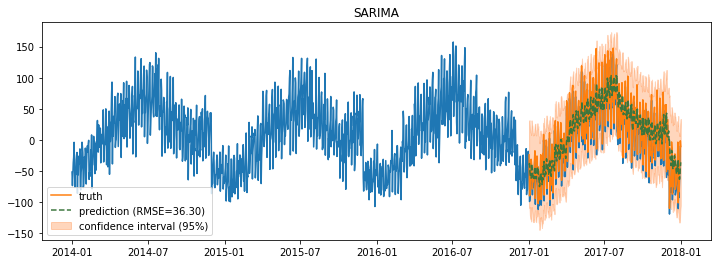

In [52]:
#Plotting original value, test values and predicted values with 95% Confidence Interval
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(indexedDataset.sales.index[100:-1], indexedDataset.sales.values[100:-1]);
ax.plot(test_st.index, test_st.values + indexedDataset.sales.iloc[-730:-365].rolling(365).mean().dropna().values, label='truth');
ax.plot(test_st.index, predicted_means, color='#3c763d', linestyle='--', label="prediction (RMSE={:0.2f})".format(sarima_rmse));
ax.fill_between(test_st.index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)");
ax.legend();
ax.set_title("SARIMA");

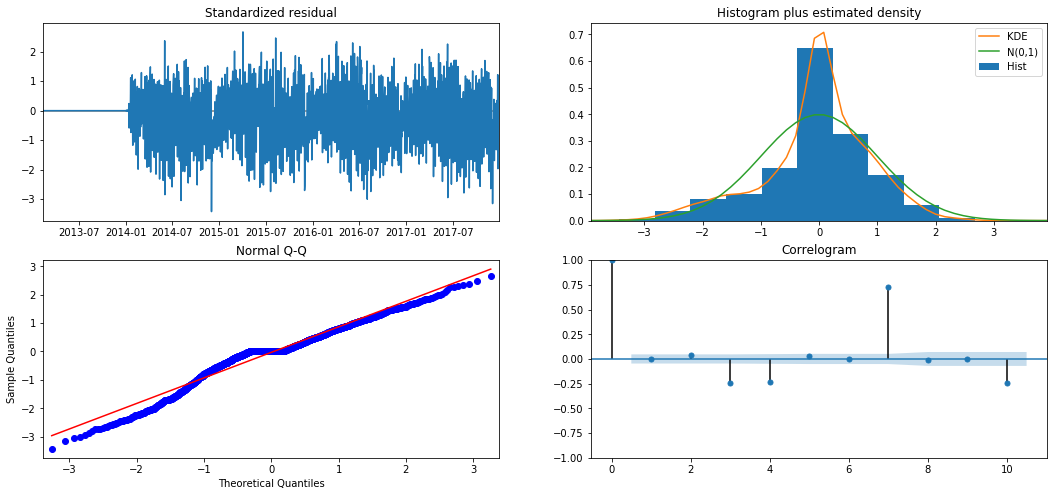

In [53]:
#Confirming stationarity of model
sarima_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

1. From above plot we can confirm our model is stationary.
2. Also RMSE for SARIMA is 36.30 which is very less as compared to Holt-Winter's test. 
3. Thus SARIMA is better fit for gives sales prediction.

In [ ]:
#Code by Sudesh V Khillare